# Projeto Titanic
- O objetivo é prever quais passageiros sobreviveram ao naufrágio.

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
plt.style.use('fivethirtyeight')

## Base de dados
- Dados sobre os passageiros do Titanic;
- Disponível no kaggle em: https://www.kaggle.com/c/titanic/data;
- O kaggle já separou os dados em treino e teste;
- Iremos analisar o conjunto de treino, pois o teste será usado para as previsões.

In [4]:
treino_titanic = pd.read_csv('train.csv')
teste_titanic = pd.read_csv('test.csv')

## Visualização dos dados

In [5]:
treino_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
treino_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Informações sobre a base de dados
Possui 891 linhas e 12 colunas que estão descritas abaixo:
- **PassagenderId:** número de identificação do passageiro;
- **Survived (Alvo):** **0** se o passageiro **não sobreviveu** e **1** se **sobreviveu**;
- **Pclass:** ticket do passageiro, 1: primeira classe, 2: segunda classe e 3: terceira classe;
- **Name:** nome;
- **Sex:** sexo, female: mulher e male: homem;
- **Age:** idade;
- **SibSP:** número de relações familiares Sibling (brother, sister, stepbrother, stepsister) ou Spouse (husband, wife) a bordo;
- **Parch:** número de relações familiares Parent ou Child a bordo;
- **Ticket:** tipo do ticket;
- **Fare:** preço do ticket;
- **Cabin:** identificação da cabine;
- **Embarked:** porto de embarque, C = Cherbourg, Q = Queenstown, S = Southampton.

## Resumo Estatístico

**Variáveis numéricas**

In [7]:
treino_titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Variáveis categóricas**

In [8]:
treino_titanic.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Mellinger, Miss. Madeleine Violet",male,347082,B96 B98,S
freq,1,577,7,4,644


## Análise exploratória de dados

### Verificando valores nulos

In [9]:
total = treino_titanic.isnull().sum().sort_values(ascending = False)
percentual = treino_titanic.isnull().sum() / treino_titanic.isnull().count().sort_values(ascending = False)
dados_nulos = pd.concat([total, percentual], axis = 1, sort = False, keys = ['nulos', 'percentual'])
dados_nulos[dados_nulos['percentual'] != 0]

,nulos,percentual
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


- Existem valores nulos na base de dados e vamos tratá-los mais para frente.

### PassengerId
- Como está coluna tem a mesma função do index da biblioteca pandas, iremos excuí-la.

In [10]:
treino_titanic.PassengerId.head()

0    1
1    2
2    3
3    4
4    5
Name: PassengerId, dtype: int64

In [11]:
treino_titanic = treino_titanic.drop(columns = ['PassengerId'])

In [12]:
treino_titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Survived
- Nossa variável alvo será **survived**, que diz se o passageiro sobreviveu. Iremos analisá-la e analisar as relações dela com as outras variáveis.

**Total de passageiros, total de sobreviventes e total de mortes**

In [13]:
passageiros = treino_titanic.Survived.count()
sobreviventes = treino_titanic.Survived.loc[treino_titanic['Survived'] == 1].count()
mortos = treino_titanic.Survived.loc[treino_titanic['Survived'] == 0].count()

print('Total de passageiros: {};\nSobreviventes: {};\nMortos: {}.'.format(passageiros, sobreviventes, mortos))

Total de passageiros: 891;
Sobreviventes: 342;
Mortos: 549.


**Plotando**

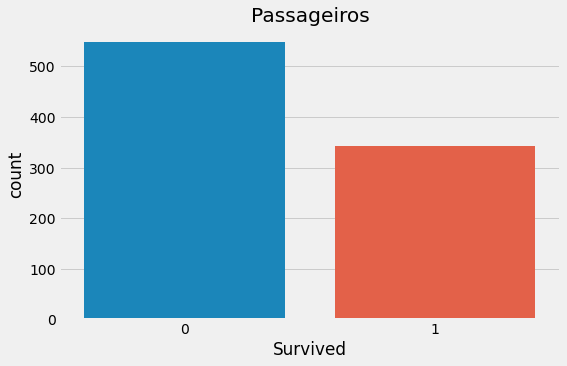

In [14]:
plt.figure(figsize = (8, 5))
sns.countplot(treino_titanic.Survived)
plt.title('Passageiros')
plt.show()

**Correlações**

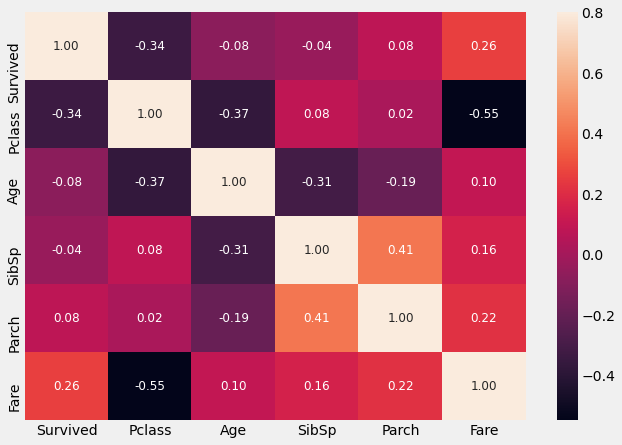

In [15]:
correlacoes = treino_titanic.corr()
#sns.set(rc = {'axes.facecolor': 'white', 'figure.facecolor': 'white'})
f, ax = plt.subplots(figsize = (10, 7))
sns.heatmap(correlacoes, vmax = .8, annot_kws = {'size': 12}, annot = True, fmt = '.2f')
plt.show()

In [16]:
corr_list = correlacoes.Survived.sort_values(axis = 0, ascending = False).iloc[1:]
corr_list

Fare      0.257307
Parch     0.081629
SibSp    -0.035322
Age      -0.077221
Pclass   -0.338481
Name: Survived, dtype: float64

### Pclass
- 1ª, 2ª ou 3º classe.

**Quantidade de passageiros por classe**

In [17]:
treino_titanic.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

**Plotando**

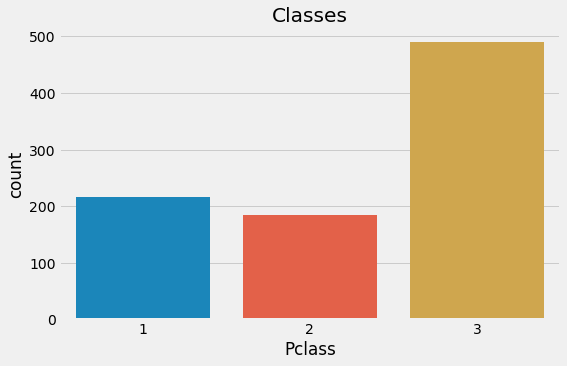

In [18]:
plt.figure(figsize = (8, 5))
sns.countplot(treino_titanic.Pclass)
plt.title('Classes')
plt.show()

**3ª classe**

In [19]:
c3 = treino_titanic.Pclass.loc[treino_titanic['Pclass'] == 3].count()
c3_sobreviventes = treino_titanic.Pclass.loc[(treino_titanic['Survived'] == 1) & (treino_titanic['Pclass'] == 3)].count()
c3_mortos = treino_titanic.Pclass.loc[(treino_titanic['Survived'] == 0) & (treino_titanic['Pclass'] == 3)].count()

print('3ª CLASSE\nTotal: {};\nSobreviventes: {};\nMortos: {}.'.format(c3, c3_sobreviventes, c3_mortos))

3ª CLASSE
Total: 491;
Sobreviventes: 119;
Mortos: 372.


**2ª classe**

In [20]:
c2 = treino_titanic.Pclass.loc[treino_titanic['Pclass'] == 2].count()
c2_sobreviventes = treino_titanic.Pclass.loc[(treino_titanic['Survived'] == 1) & (treino_titanic['Pclass'] == 2)].count()
c2_mortos = treino_titanic.Pclass.loc[(treino_titanic['Survived'] == 0) & (treino_titanic['Pclass'] == 2)].count()

print('2ª CLASSE\nTotal: {};\nSobreviventes: {};\nMortos: {}.'.format(c2, c2_sobreviventes, c2_mortos))

2ª CLASSE
Total: 184;
Sobreviventes: 87;
Mortos: 97.


**1ª classe**

In [21]:
c1 = treino_titanic.Pclass.loc[treino_titanic['Pclass'] == 1].count()
c1_sobreviventes = treino_titanic.Pclass.loc[(treino_titanic['Survived'] == 1) & (treino_titanic['Pclass'] == 1)].count()
c1_mortos = treino_titanic.Pclass.loc[(treino_titanic['Survived'] == 0) & (treino_titanic['Pclass'] == 1)].count()

print('1ª CLASSE\nTotal: {};\nSobreviventes: {};\nMortos: {}.'.format(c1, c1_sobreviventes, c1_mortos))

1ª CLASSE
Total: 216;
Sobreviventes: 136;
Mortos: 80.


**Sobreviventes e mortos por classe**

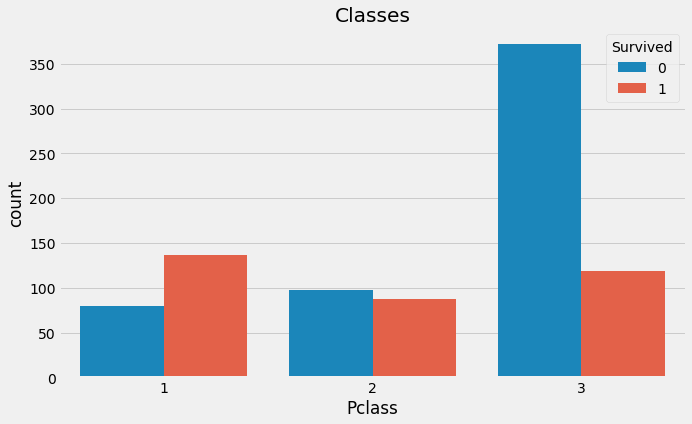

In [22]:
plt.figure(figsize = (10, 6))
sns.countplot(treino_titanic.Pclass, hue = treino_titanic.Survived)
plt.title('Classes')
plt.show()

### Name
- Como o nome serve apenas como identificação dos passageiros, podemos excluí-lo no modelo de previsão.

In [23]:
treino_titanic.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [24]:
treino_titanic = treino_titanic.drop(columns = ['Name'])

In [25]:
treino_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


### Sex

**Total de homens e mulheres**

In [26]:
treino_titanic.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

**Plotando**

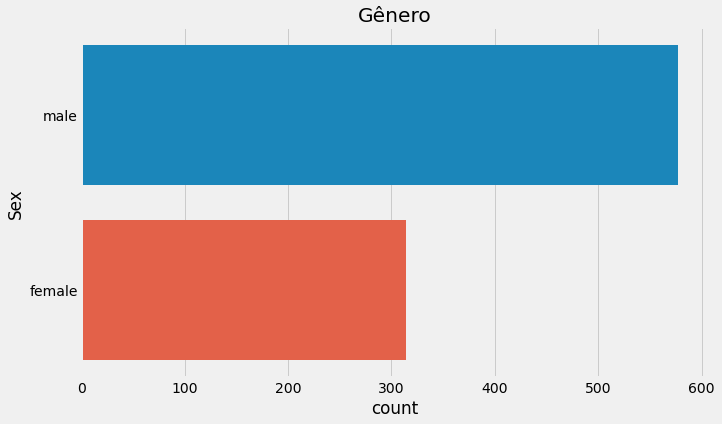

In [27]:
plt.figure(figsize = (10, 6))
sns.countplot(y = treino_titanic.Sex)
plt.title('Gênero')
plt.show()

**Mulheres**

In [28]:
mulheres = treino_titanic.Pclass.loc[treino_titanic['Sex'] == 'female'].count()
mulheres_sobreviventes = treino_titanic.Pclass.loc[(treino_titanic['Survived'] == 1) & (treino_titanic['Sex'] == 'female')].count()
mulheres_mortas = treino_titanic.Pclass.loc[(treino_titanic['Survived'] == 0) & (treino_titanic['Sex'] == 'female')].count()

print('MULHERES\nTotal: {};\nSobreviventes: {};\nMortas: {}.'.format(mulheres, mulheres_sobreviventes, mulheres_mortas))

MULHERES
Total: 314;
Sobreviventes: 233;
Mortas: 81.


**Homens**

In [29]:
homens = treino_titanic.Pclass.loc[treino_titanic['Sex'] == 'male'].count()
homens_sobreviventes = treino_titanic.Pclass.loc[(treino_titanic['Survived'] == 1) & (treino_titanic['Sex'] == 'male')].count()
homens_mortos = treino_titanic.Pclass.loc[(treino_titanic['Survived'] == 0) & (treino_titanic['Sex'] == 'male')].count()

print('HOMENS\nTotal: {};\nSobreviventes: {};\nMortos: {}.'.format(homens, homens_sobreviventes, homens_mortos))

HOMENS
Total: 577;
Sobreviventes: 109;
Mortos: 468.


**Sobreviventes e mortos por gênero**

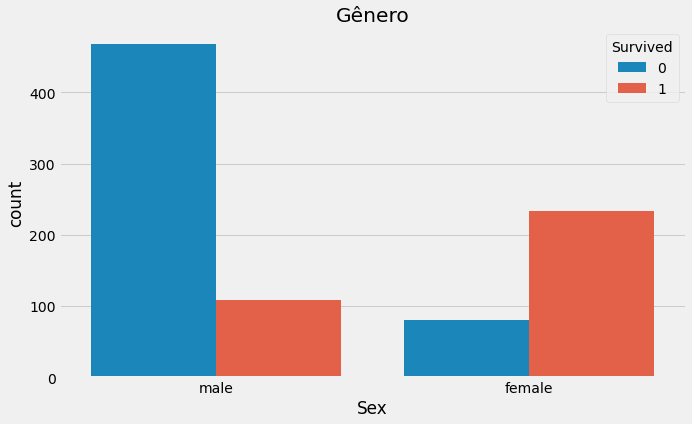

In [30]:
plt.figure(figsize = (10, 6))
sns.countplot(treino_titanic.Sex, hue = treino_titanic.Survived)
plt.title('Gênero')
plt.show()

## Age

**Maior, menor e idade média**

In [31]:
menor_idade = treino_titanic.Age.min()
maior_idade = treino_titanic.Age.max()
idade_media = round(treino_titanic.Age.mean(), 2)

print('IDADE\nPassageiro mais novo: {} anos;\nIdade média: {} anos;\nPassageiro mais velho: {} anos.'.format(menor_idade, idade_media, maior_idade))

IDADE
Passageiro mais novo: 0.42 anos;
Idade média: 29.7 anos;
Passageiro mais velho: 80.0 anos.


**Plotando a distribuição da idade**

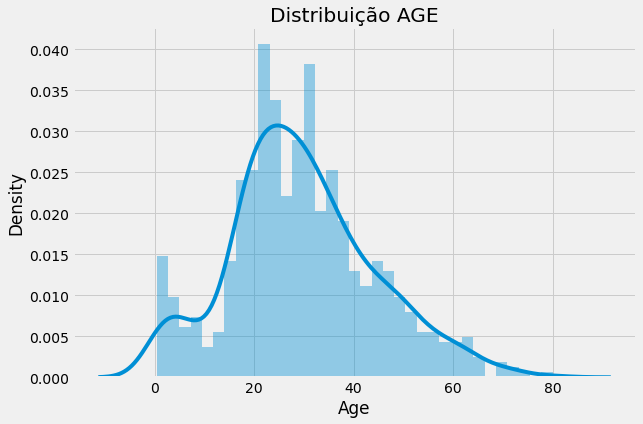

In [32]:
plt.figure(figsize = (9, 6))
sns.distplot(treino_titanic.Age, bins = 35)
plt.title('Distribuição AGE')
plt.show()

**Boxplot Age**

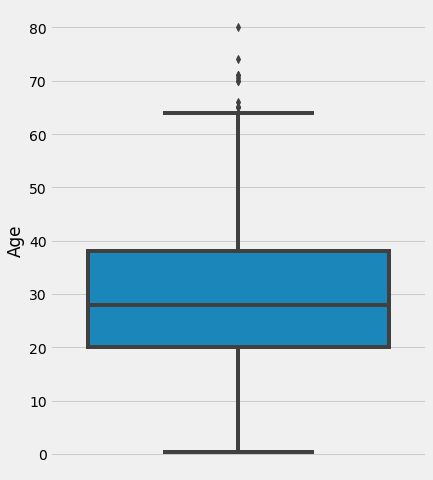

In [33]:
plt.figure(figsize = (6, 8))
sns.boxplot(y = 'Age', data = treino_titanic)
plt.show()

**Preenchendo valores nulos**
- Como vimos um pouco acima, Age é uma das colunas com valores nulos e vamos preenchê-la com a idade média da base.

In [34]:
treino_titanic.Age = treino_titanic.Age.fillna(idade_media)

**Outliers**
- Vamos calcular as barreiras externas inferior e superior da coluna idade para identificar os outliers.

In [35]:
def quartil(coluna):
    q1 = treino_titanic[coluna].quantile(q= 0.25)
    q3 = treino_titanic[coluna].quantile(q= 0.75)
    amplitude = q3 - q1
    print('QUARTIS {}\n- Q1 = {}, Q3 = {}, amplitude = {}.'.format(coluna, q1, q3, amplitude))
    # Calculando a barreira externa
    limite_max = q3 + 3 * amplitude
    limite_min = q1 - 3 * amplitude
    print('- Barreira externa inferior: {} | Barreira externa superior: {}.'.format(limite_min, limite_max))
    
quartil('Age')

QUARTIS Age
- Q1 = 22.0, Q3 = 35.0, amplitude = 13.0.
- Barreira externa inferior: -17.0 | Barreira externa superior: 74.0.


**Substituindo os outliers severos**
- Outliers < barreira externa inferior: como o menor valor da coluna é 0, não temos outliers menores que a barreira externa inferior;
- Outliers > barreira externa superior: iremos substituir os outliers pelo valor da barreira externa superior.

In [36]:
treino_titanic.Age.loc[treino_titanic.Age > 74] = 74

C:\Users\Umbroso\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


**Verificando**

In [37]:
menor_idade = treino_titanic.Age.min()
maior_idade = treino_titanic.Age.max()
idade_media = round(treino_titanic.Age.mean(), 2)

print('IDADE\nPassageiro mais novo: {} anos;\nIdade média: {} anos;\nPassageiro mais velho: {} anos.'.format(menor_idade, idade_media, maior_idade))

IDADE
Passageiro mais novo: 0.42 anos;
Idade média: 29.69 anos;
Passageiro mais velho: 74.0 anos.


### SibSp

**Quantidade de passageiros por SibSp**

In [38]:
treino_titanic.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

**Plotando**

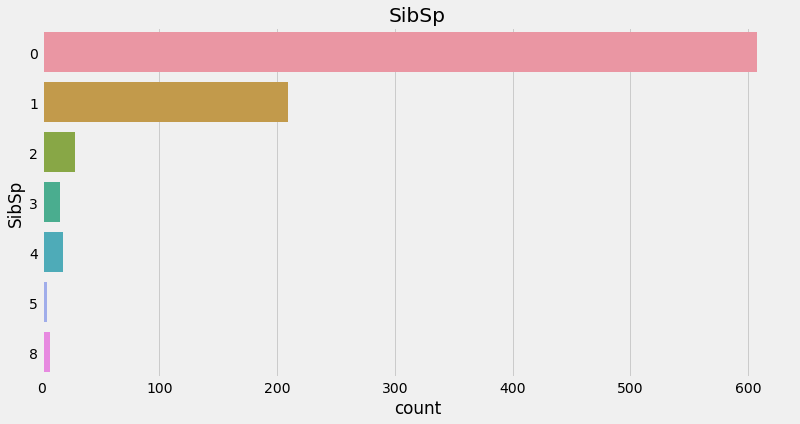

In [39]:
plt.figure(figsize = (12, 6))
sns.countplot(y = treino_titanic.SibSp)
plt.title('SibSp')
plt.show()

**Plotando sobreviventes e mortos por SibSp**

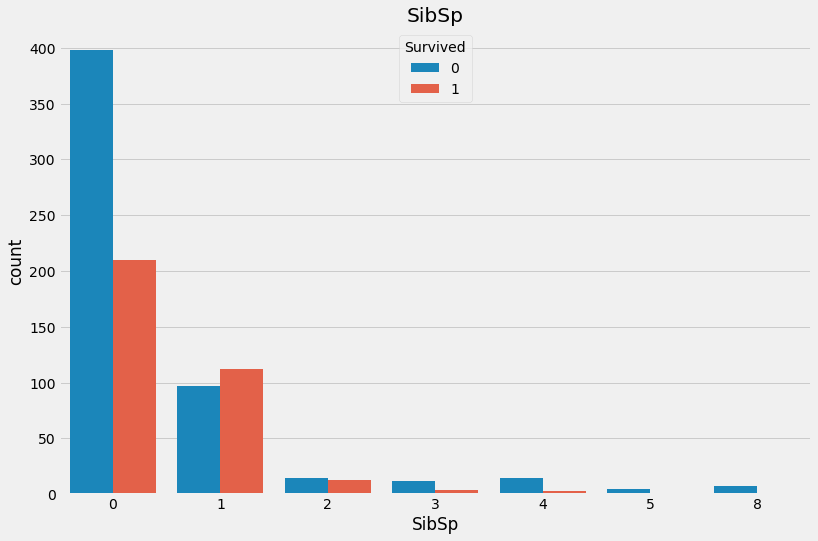

In [40]:
plt.figure(figsize = (12, 8))
sns.countplot(treino_titanic.SibSp, hue = treino_titanic.Survived)
plt.title('SibSp')
plt.show()

### Parch

**Quantidade de passageiros por Parch**

In [41]:
treino_titanic.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

**Plotando sobreviventes e mortos por Parch**

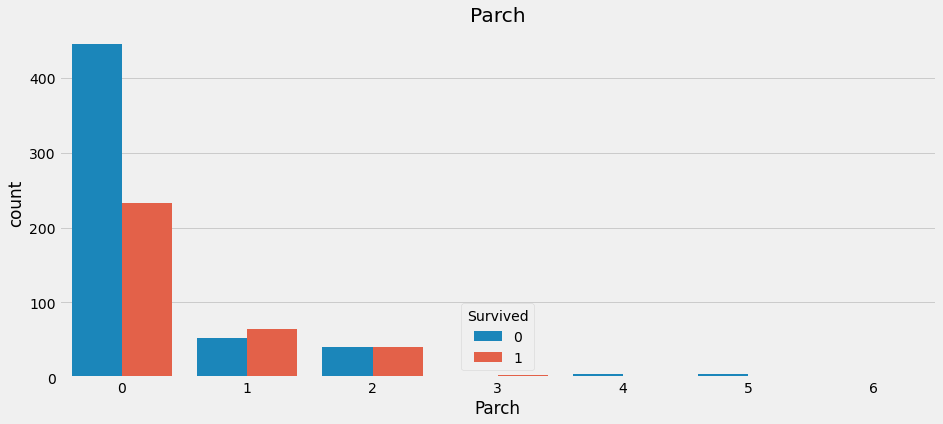

In [42]:
plt.figure(figsize = (14, 6))
sns.countplot(treino_titanic.Parch, hue = treino_titanic.Survived)
plt.title('Parch')
plt.show()

### Ticket
- Como a coluna ticket mostra apenas a identificação do ticket do passageiro, ela não será muito relevante para o modelo, então iremos excuí-la.

In [43]:
treino_titanic.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [44]:
treino_titanic = treino_titanic.drop(columns = ['Ticket'])

In [45]:
treino_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


### Fare

**Maior, menor e tarifa média**

In [46]:
menor_preco = treino_titanic.Fare.min()
maior_preco = treino_titanic.Fare.max()
preco_medio = round(treino_titanic.Fare.mean(), 2)

print('Preço\nMenor preço: {};\nPreço médio: {};\nMaior preço: {}.'.format(menor_preco, preco_medio, maior_preco))

Preço
Menor preço: 0.0;
Preço médio: 32.2;
Maior preço: 512.3292.


**Plotando a distribuição das tarifas**

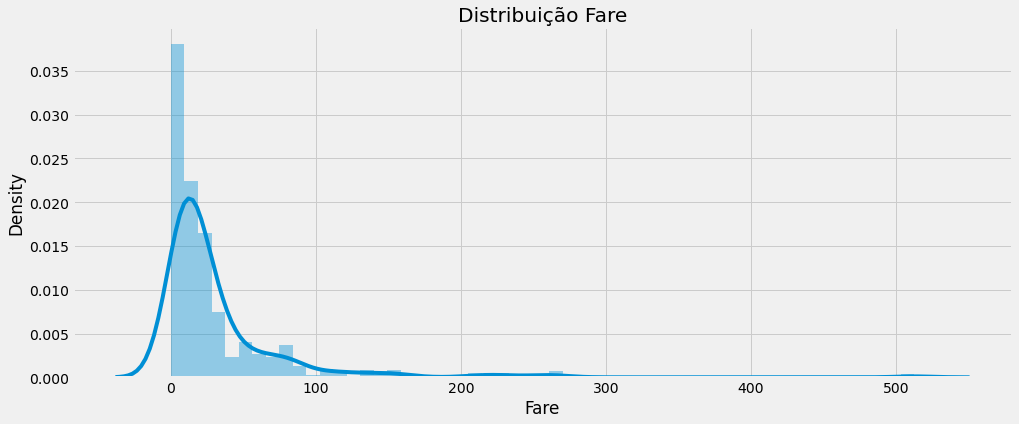

In [47]:
plt.figure(figsize = (15, 6))
sns.distplot(treino_titanic.Fare, bins = 55)
plt.title('Distribuição Fare')
plt.show()

**Boxplot Fare**

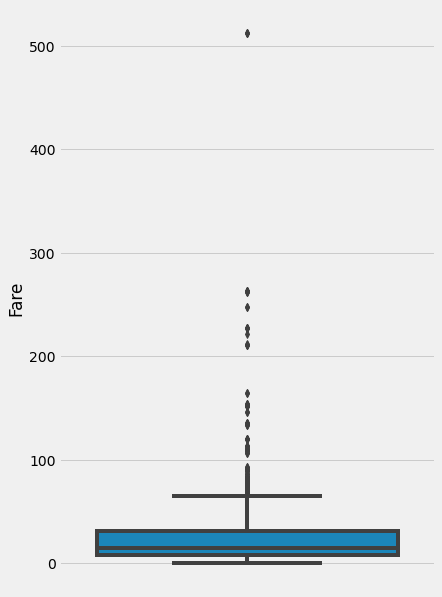

In [48]:
plt.figure(figsize = (6, 10))
sns.boxplot(y = 'Fare', data = treino_titanic)
plt.show()

**Preenchendo valores nulos**
- Como vimos um pouco acima, Fare é uma das colunas com valores nulos e vamos preenchê-la com a preço médio da tarifa.

In [49]:
treino_titanic.Fare = treino_titanic.Fare.fillna('32.2')

**Outliers**
- Vamos calcular as barreiras externas inferior e superior da coluna idade para identificar os outliers.

In [50]:
quartil('Fare')

QUARTIS Fare
- Q1 = 7.9104, Q3 = 31.0, amplitude = 23.0896.
- Barreira externa inferior: -61.358399999999996 | Barreira externa superior: 100.2688.


**Substituindo os outliers severos**
- Outliers < barreira externa inferior: como o menor valor da coluna é 0, não temos outliers menores que a barreira externa inferior;
- Outliers > barreira externa superior: iremos substituir os outliers pelo valor da barreira externa superior.

In [51]:
treino_titanic.Fare.loc[treino_titanic.Fare > 100] = 100

C:\Users\Umbroso\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


**Verificando**

In [52]:
menor_preco = treino_titanic.Fare.min()
maior_preco = treino_titanic.Fare.max()
preco_medio = round(treino_titanic.Fare.mean(), 2)

print('Preço\nMenor preço: {};\nPreço médio: {};\nMaior preço: {}.'.format(menor_preco, preco_medio, maior_preco))

Preço
Menor preço: 0.0;
Preço médio: 27.03;
Maior preço: 100.0.


### Cabin
- Como a coluna Cabin mostra apenas a identificação da cabine do passageiro, ela não será muito relevante para o modelo, então iremos excuí-la.

In [53]:
treino_titanic.Cabin.head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [54]:
treino_titanic = treino_titanic.drop(columns = ['Cabin'])

In [55]:
treino_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Embarked

**Quantidade de passageiros por portos**

In [56]:
treino_titanic.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

**Plotando**

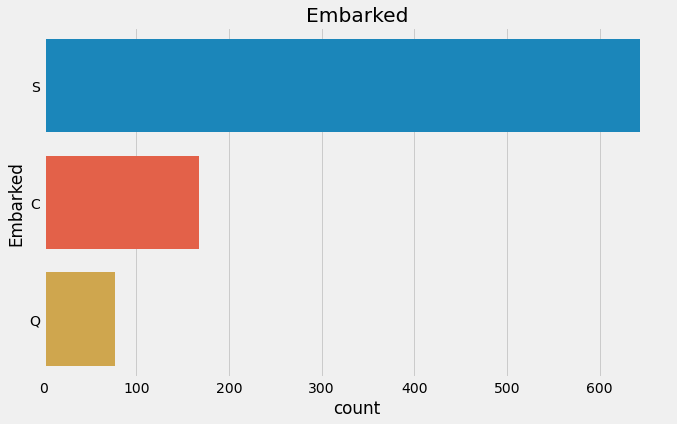

In [57]:
plt.figure(figsize = (10, 6))
sns.countplot(y = treino_titanic.Embarked)
plt.title('Embarked')
plt.show()

**Sobreviventes e mortos por porto**

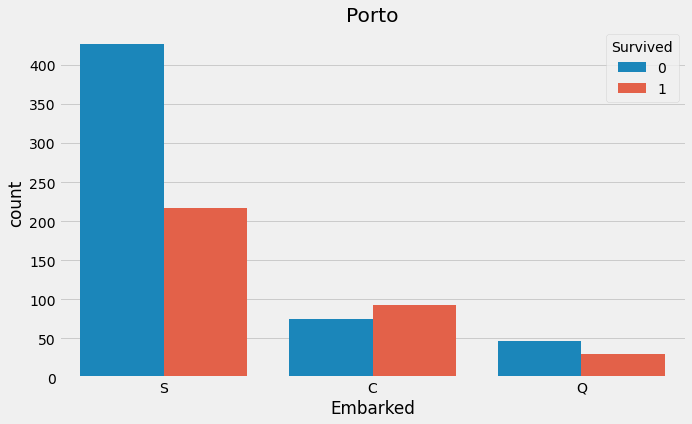

In [58]:
plt.figure(figsize = (10, 6))
sns.countplot(treino_titanic.Embarked, hue = treino_titanic.Survived)
plt.title('Porto')
plt.show()

**Preenchendo valores nulos**
- Como vimos um pouco acima, Embarked é uma das colunas com valores nulos e vamos preenchê-la com o porto mais comum: S.

In [59]:
treino_titanic.Embarked = treino_titanic.Embarked.fillna('S')

### Verificando valores nulos novamente

In [60]:
total = treino_titanic.isnull().sum().sort_values(ascending = False)
percentual = treino_titanic.isnull().sum() / treino_titanic.isnull().count().sort_values(ascending = False)
dados_nulos = pd.concat([total, percentual], axis = 1, sort = False, keys = ['nulos', 'percentual'])
dados_nulos[dados_nulos['percentual'] != 0]

,nulos,percentual


- Nosso dataset não possui mais valores nulos.

### Transformando variáveis categóricas em numéricas

In [61]:
treino_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [62]:
treino_titanic = treino_titanic.astype({'Sex': 'category', 'Embarked': 'category'})

In [63]:
categoricas = treino_titanic[treino_titanic.select_dtypes('category').columns]

for cat in categoricas:
    encoding = LabelEncoder()
    encoding.fit(list(treino_titanic[cat].values))
    treino_titanic[cat] = encoding.transform(list(treino_titanic[cat].values))
    
treino_titanic = pd.get_dummies(treino_titanic)

In [64]:
treino_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


## Tratamento dos dados de teste

### Deletando colunas desnecessárias

In [69]:
teste_titanic = teste_titanic.drop(columns = ['PassengerId','Name','Cabin', 'Ticket'])

In [70]:
teste_titanic.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


### Verificando valores nulos Test

In [71]:
total_teste = teste_titanic.isnull().sum().sort_values(ascending = False)
percentual_teste = teste_titanic.isnull().sum() / teste_titanic.isnull().count().sort_values(ascending = False)
dados_nulos_teste = pd.concat([total_teste, percentual_teste], axis = 1, sort = False, keys = ['nulos', 'percentual'])
dados_nulos_teste[dados_nulos_teste['percentual'] != 0]

,nulos,percentual
Age,86,0.205742
Fare,1,0.002392


**Preenchendo nulos com as médias das colunas do dataset de treino**

In [72]:
teste_titanic.Age = treino_titanic.Age.fillna(idade_media)
teste_titanic.Fare = treino_titanic.Fare.fillna('32.2')

**Verificando novamente**

In [73]:
total_teste = teste_titanic.isnull().sum().sort_values(ascending = False)
percentual_teste = teste_titanic.isnull().sum() / teste_titanic.isnull().count().sort_values(ascending = False)
dados_nulos_teste = pd.concat([total_teste, percentual_teste], axis = 1, sort = False, keys = ['nulos', 'percentual'])
dados_nulos_teste[dados_nulos_teste['percentual'] != 0]

,nulos,percentual


### Transformando variáveis categóricas em numéricas

In [74]:
teste_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


In [75]:
teste_titanic = teste_titanic.astype({'Sex': 'category', 'Embarked': 'category'})

In [76]:
categoricas_teste = teste_titanic[teste_titanic.select_dtypes('category').columns]

for cat in categoricas_teste:
    encoding = LabelEncoder()
    encoding.fit(list(teste_titanic[cat].values))
    teste_titanic[cat] = encoding.transform(list(teste_titanic[cat].values))
    
teste_titanic = pd.get_dummies(teste_titanic)

In [77]:
teste_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 23.0 KB


## Colunas mais importantes

### Separando a variável alvo (Survived)

In [78]:
previsores = treino_titanic.drop('Survived', axis = 1)
alvo = treino_titanic.Survived

### Random forest classifier
- Iremos usar Random Forest para analisar quais serão as colunas mais importantes para gerar os modelos.

In [79]:
clf = RandomForestClassifier(n_estimators = 100, random_state = 7)
clf.fit(previsores, alvo)

RandomForestClassifier(random_state=7)

In [80]:
feature_imp = pd.Series(clf.feature_importances_, index = previsores.columns).sort_values(ascending = False)
feature_imp

Fare        0.270147
Age         0.267449
Sex         0.255682
Pclass      0.086098
SibSp       0.048633
Parch       0.038558
Embarked    0.033433
dtype: float64

**Plotando**

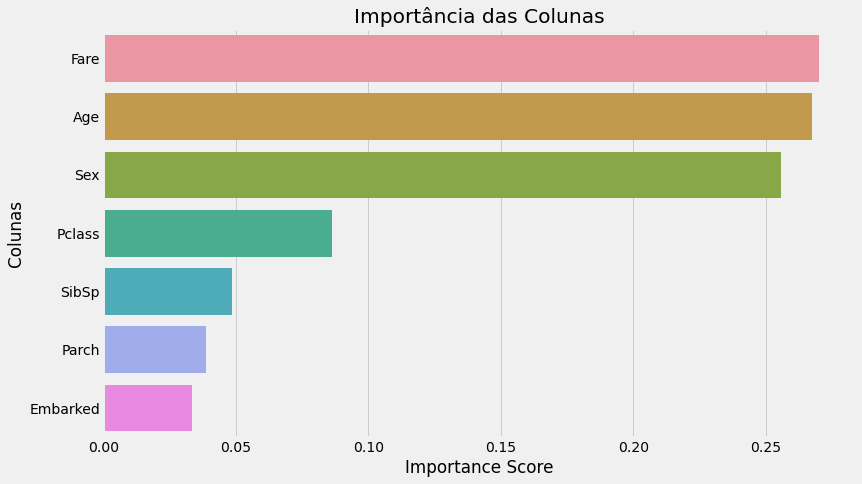

In [81]:
plt.figure(figsize = (12, 7))
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Importance Score')
plt.ylabel('Colunas')
plt.title('Importância das Colunas')
plt.show()

### Selecionando as colunas com maior impotância
- Usaremos apenas as colunas com importância maior do que 5%.

In [82]:
previsores = []
print('IMPORTÂNCIA')
for feature, importance in feature_imp.iteritems():
    if importance > 0.05:
        print('{}: {}%'.format(feature, (round(importance * 100))))
        previsores.append(feature)

IMPORTÂNCIA
Fare: 27%
Age: 27%
Sex: 26%
Pclass: 9%


### Treinando os modelos utilizando apenas as colunas selecionadas

In [83]:
X_train = treino_titanic[previsores].values
X_test = teste_titanic[previsores].values
y_train = treino_titanic.Survived.values

## Modelos de previsão

### Modelos
- Iremos testar diferentes modelos de duas formas diferentes: sem modificar os dados e colocando os dados na mesma escala;
- Vamos aplicar a técnica de **padronização** aos dados, os dados serão ficarão com uma distribuição normal, com média zero e desvio padrão igual a 1.

In [84]:
pipelines = []
pipelines.append(('LR', Pipeline([('LR', LogisticRegression())])))
pipelines.append(('Scaled LR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('KNN', Pipeline([('KNN', KNeighborsClassifier())])))
pipelines.append(('Scaled KNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('CART', Pipeline([('CART', DecisionTreeClassifier())])))
pipelines.append(('Scaled CART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('NB', Pipeline([('NB', GaussianNB())])))
pipelines.append(('Scaled NB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('SVC', Pipeline([('SVM', SVC())])))
pipelines.append(('Scaled SVC', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))
pipelines.append(('RF', Pipeline([('RF', RandomForestClassifier())])))
pipelines.append(('Scaled RF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestClassifier())])))

### Comparando os modelos

In [85]:
resultados = []
nomes = []

print('MODELOS')

for nome, modelo in pipelines:
    kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 7)
    cross_val_result = model_selection.cross_val_score(modelo, X_train, y_train, cv = kfold, scoring = 'accuracy')
    resultados.append(cross_val_result)
    nomes.append(nome)
    print('- {}: {} | ({})'.format(nome, cross_val_result.mean(), cross_val_result.std()))

MODELOS
- LR: 0.7900499375780276 | (0.04842754561092061)
- Scaled LR: 0.7933957553058677 | (0.05224686883231985)
- KNN: 0.7227965043695381 | (0.02497922378712855)
- Scaled KNN: 0.8338451935081148 | (0.03026256628215354)
- CART: 0.7799625468164795 | (0.04493796778375089)
- Scaled CART: 0.7765917602996255 | (0.04956041244963741)
- NB: 0.7631210986267166 | (0.038390444859433576)
- Scaled NB: 0.7631210986267166 | (0.038390444859433576)
- SVC: 0.679063670411985 | (0.043122408853773664)
- Scaled SVC: 0.8159051186017479 | (0.028683270637223923)
- RF: 0.8349812734082395 | (0.03532381273293794)
- Scaled RF: 0.8259675405742822 | (0.0365355757251152)


## Etapa de Tuning
- Como os algoritmos KNN em escala e Random Forest mostraram os melhores resultados, iremos melhorá-los ainda mais escolhendo seus melhores parâmetros.

### KNN

**Parâmetro k**

In [86]:
k_list = list(range(1, 31))

**Métrica**

In [87]:
metrics = ['minkowski', 'hamming', 'manhattan', 'euclidean', 'cosine', 'jaccard']

**Dicionário**

In [88]:
knn_params_grid = dict(n_neighbors = k_list, metric = metrics)

**Escala**

In [89]:
scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train)

**Testando os parâmetros**

In [90]:
modelo_knn = KNeighborsClassifier()
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 7)
grid = RandomizedSearchCV(estimator = modelo_knn, param_distributions = knn_params_grid, cv = kfold, scoring = 'accuracy')
grid.fit(X_train_sca, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
                   estimator=KNeighborsClassifier(),
                   param_distributions={'metric': ['minkowski', 'hamming',
                                                   'manhattan', 'euclidean',
                                                   'cosine', 'jaccard'],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29, 30]},
                   scoring='accuracy')

**Melhores parâmetros**

In [91]:
print('KNN - MELHORES PARÂMETROS:\n')
means = grid.cv_results_['mean_test_score'].round(5)
stds = grid.cv_results_['std_test_score'].round(5)

for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print('Mean: {}, std: {}, params: {};'.format(mean, std, params))
    
print('\nMelhor parâmetro: {}, score: {}.'.format(grid.best_params_, grid.best_score_))

KNN - MELHORES PARÂMETROS:

Mean: 0.79458, std: 0.03351, params: {'n_neighbors': 28, 'metric': 'minkowski'};
Mean: 0.83499, std: 0.01966, params: {'n_neighbors': 6, 'metric': 'manhattan'};
Mean: 0.79685, std: 0.03876, params: {'n_neighbors': 22, 'metric': 'cosine'};
Mean: 0.56898, std: 0.09355, params: {'n_neighbors': 19, 'metric': 'jaccard'};
Mean: 0.79116, std: 0.03863, params: {'n_neighbors': 15, 'metric': 'hamming'};
Mean: 0.80466, std: 0.03653, params: {'n_neighbors': 15, 'metric': 'cosine'};
Mean: 0.56898, std: 0.09355, params: {'n_neighbors': 16, 'metric': 'jaccard'};
Mean: 0.80016, std: 0.03352, params: {'n_neighbors': 14, 'metric': 'euclidean'};
Mean: 0.79236, std: 0.04615, params: {'n_neighbors': 27, 'metric': 'cosine'};
Mean: 0.80017, std: 0.02725, params: {'n_neighbors': 10, 'metric': 'hamming'};

Melhor parâmetro: {'n_neighbors': 6, 'metric': 'manhattan'}, score: 0.8349937578027464.


### Random Forest

**Estimators**

In [92]:
estimators = [20, 50, 100, 150, 200]

**Critério de divisão**

In [93]:
criterion = ['gini', 'entropy']

**Dicionário**
- Criaremos um dicionário para guardar os valores dos parâmetros a serem testados.

In [94]:
rf_params_grid = dict(n_estimators = estimators, criterion = criterion)

**Testando os parâmetros**

In [95]:
modelo_random = RandomForestClassifier()
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 7)
grid = RandomizedSearchCV(estimator = modelo_random, param_distributions = rf_params_grid, cv = kfold, scoring = 'accuracy')
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
                   estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'n_estimators': [20, 50, 100, 150,
                                                         200]},
                   scoring='accuracy')

**Melhores parâmetros**

In [96]:
print('RANDOM FOREST - MELHORES PARÂMETROS:\n')
means = grid.cv_results_['mean_test_score'].round(5)
stds = grid.cv_results_['std_test_score'].round(5)

for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print('Mean: {}, std: {}, params: {};'.format(mean, std, params))
    
print('\nMelhor parâmetro: {}, score: {}.'.format(grid.best_params_, grid.best_score_))

RANDOM FOREST - MELHORES PARÂMETROS:

Mean: 0.83608, std: 0.03127, params: {'n_estimators': 20, 'criterion': 'gini'};
Mean: 0.82934, std: 0.03637, params: {'n_estimators': 50, 'criterion': 'gini'};
Mean: 0.82709, std: 0.0372, params: {'n_estimators': 100, 'criterion': 'gini'};
Mean: 0.83273, std: 0.03327, params: {'n_estimators': 150, 'criterion': 'gini'};
Mean: 0.82823, std: 0.03678, params: {'n_estimators': 200, 'criterion': 'gini'};
Mean: 0.82039, std: 0.02433, params: {'n_estimators': 20, 'criterion': 'entropy'};
Mean: 0.82598, std: 0.0351, params: {'n_estimators': 50, 'criterion': 'entropy'};
Mean: 0.82263, std: 0.02669, params: {'n_estimators': 100, 'criterion': 'entropy'};
Mean: 0.8316, std: 0.03389, params: {'n_estimators': 150, 'criterion': 'entropy'};
Mean: 0.82824, std: 0.03426, params: {'n_estimators': 200, 'criterion': 'entropy'};

Melhor parâmetro: {'n_estimators': 20, 'criterion': 'gini'}, score: 0.836079900124844.


## Preparando o modelo para submissão
- Como o algoritmo Random Forest foi o que obteve melhores resultados, vamos usá-lo para a previsão do grupo teste.

### Random Forest

In [103]:
rf_final = RandomForestClassifier(n_estimators=20, criterion='gini', random_state=7)
rf_final.fit(X_train,y_train)
prev_rf = rf_final.predict(X_test)

### Submetendo o modelo

In [ ]:
teste = pd.read_csv('test.csv')

In [104]:
submission = pd.DataFrame({
        'PassengerId': teste['PassengerId'],
        'Survived': prev_rf})

In [105]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


**Salvando**

In [106]:
submission.to_csv('submission.csv', index=False)